In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# Import Data

In [2]:
import pickle
import numpy as np

data_path_age = "../data/age_data.pkl"
data_path_working_hours = "../data/working_hours_data.pkl"

DATASET = []
## Load Data ##
with open(data_path_age, "rb") as f:
    data = pickle.load(f)
    data = np.concatenate([data] * 10)
    DATASET.append({"data":   np.sort(data),
                    "bounds": (0, 100),
                    "g":      1,
                    "name":   "age",
                    "n":      len(data), })
with open(data_path_working_hours, "rb") as f:
    data = pickle.load(f)
    data = np.concatenate([data] * 10)
    DATASET.append({"data":   np.sort(data),
                    "bounds": (0, 100),
                    "g":      1,
                    "name":   "working_hours",
                    "n":      len(data), })

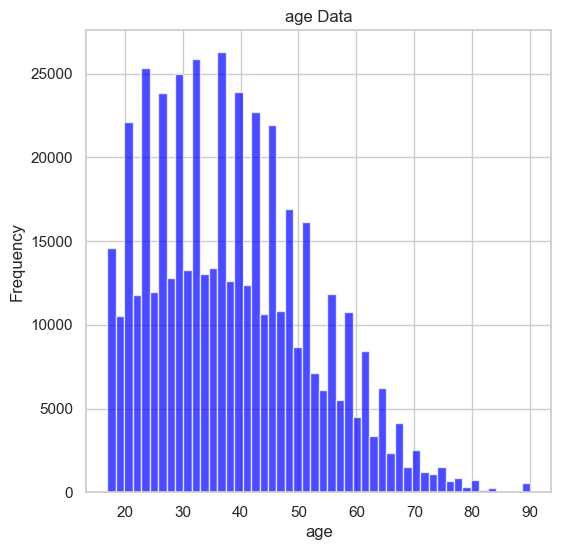

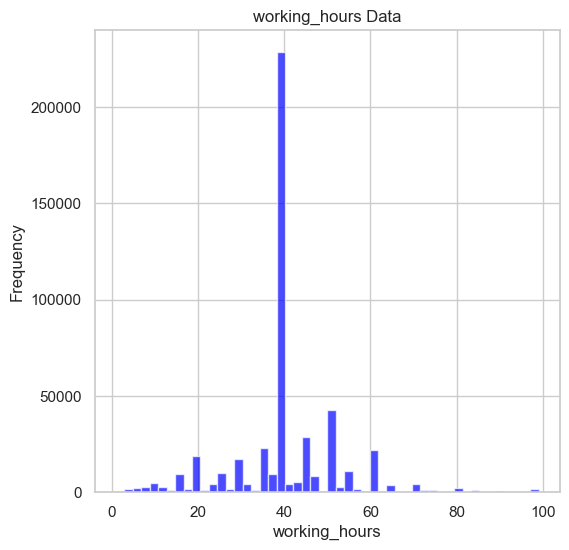

In [3]:
# print histogram
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
for dataset in DATASET:
    data = dataset["data"]
    plt.figure(figsize=(6, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(f"{dataset['name']} Data")
    plt.xlabel(dataset["name"])
    plt.ylabel("Frequency")
    plt.show()

## Post process, add small noise

In [4]:
std = 1e-3
for dataset in DATASET:
    dataset["data"] = np.sort(dataset["data"] + np.random.normal(0, std, size=dataset["data"].shape))
    dataset["g"] = std / len(dataset["data"])

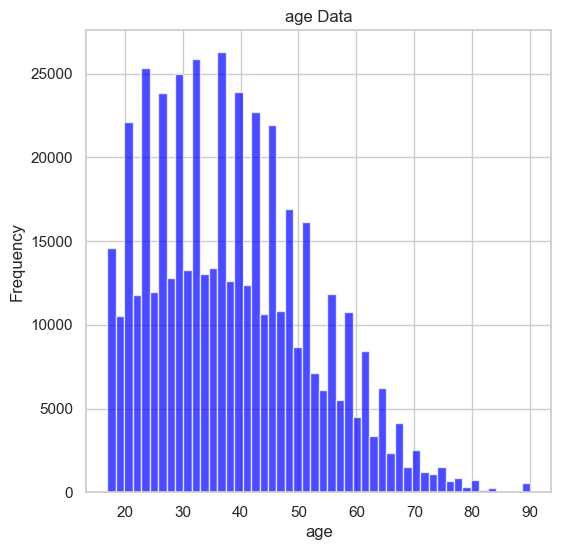

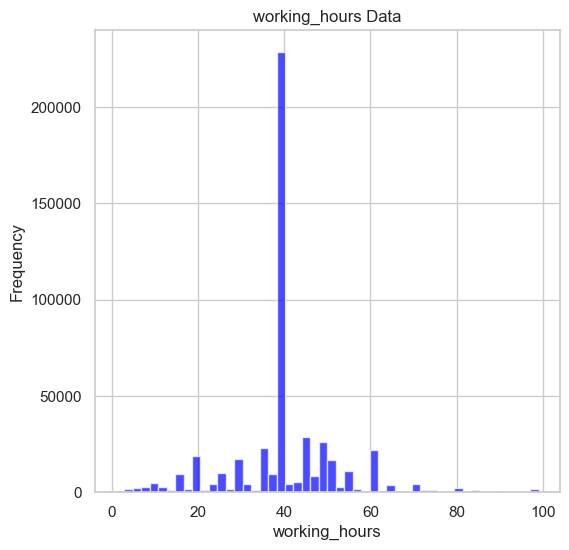

In [5]:
# print histogram
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
for dataset in DATASET:
    data = dataset["data"]
    plt.figure(figsize=(6, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(f"{dataset['name']} Data")
    plt.xlabel(dataset["name"])
    plt.ylabel("Frequency")
    plt.show()

# Set Privacy Budgets

We propose $\varepsilon, \delta$ that are used in SliceQuantiles, and compute the highest $\rho$ for zCDP that implies the same $\varepsilon, \delta$.

In [6]:
from scipy.optimize import root_scalar
import numpy as np


def get_max_rho(eps, delta):
    """
    Get the maximum rho for a given epsilon and delta.
    """
    epsilon_func = lambda rho: rho + np.sqrt(4 * rho * np.log(np.sqrt(np.pi * rho) / delta)) - eps

    # Use a numerical solver to find the root of epsilon_func
    result = root_scalar(epsilon_func, bracket=[1e-10, 10], method='brentq')

    if result.converged:
        return result.root
    else:
        raise ValueError("Failed to find a valid rho for the given epsilon and delta.")


eps = 1.
delta = 1e-16
rho = get_max_rho(eps, delta)
print("For eps = {}, delta = {}, max rho = {}".format(eps, delta, rho))

For eps = 1.0, delta = 1e-16, max rho = 0.007055178225814259


# Hyperparameters

In [7]:
EPS = 1.  # like the one used for the dataset
DELTA = 1e-16
RHO = get_max_rho(EPS, DELTA)
M_LIST = range(10, 251, 10)
SWAP = True
NUM_EXPERIMENTS = 50
max_q_list = np.linspace(0, 1, max(M_LIST) + 2)[1:-1]

for dataset in DATASET:
    # add the q_list key
    dataset["q_list"] = max_q_list

In [8]:
records = []  # to store the records of each experiment

In [9]:
import math


def get_statistics(X: np.ndarray, quantiles: np.ndarray, estimates: np.ndarray) -> float:
    """
    Compute the maximum rank error and the mean absolute rank error between the true quantiles and the estimated quantiles.
    :param X: data set
    :param quantiles: a list of quantiles (values in [0, 1])
    :param estimates: a list of estimated qth-quantiles (values in X)
    :return: a dictionary with the maximum rank error and the mean absolute rank error
    """
    # sort the data
    X = np.sort(X)
    n = len(X)

    # for each result, get the position of the closest element in the sorted array
    positions = np.searchsorted(X, estimates)
    true_positions = [math.floor(q * n) for q in quantiles]

    # compute the normalized rank error
    rank_errors = np.abs(positions - true_positions)

    # get statistics
    max_rank_error = np.max(rank_errors)
    mean_rank_error = np.mean(rank_errors)
    output = {
        'max_error':  max_rank_error,
        'mean_error': mean_rank_error  # Kaplan et al. uses this
    }
    return output


# Run SliceQuantiles

## Check correcteness of the privacy parameters

In [10]:
from our_mechanism import SliceQuantile

# Check if the privacy parameters are valid for any values of m
for data_dict in DATASET:
    bound = data_dict["bounds"]
    g = data_dict["g"]
    N = data_dict["n"]
    q_list = data_dict["q_list"]
    mechanism = SliceQuantile(bound=bound, n=N, m=len(q_list), eps=EPS, split=0.5, swap=SWAP, g=g)
    if not mechanism.is_delta_approximate_DP(delta=DELTA, q_list=q_list):
        raise ValueError(f"For n={N} failed to find a valid delta approximate DP.")
print("All privacy parameters are valid for the given m values.")

All privacy parameters are valid for the given m values.


## Run the experiments

In [11]:
from tqdm import tqdm

for data_dict in DATASET:
    bound = data_dict["bounds"]
    data = data_dict["data"]
    g = data_dict["g"]
    N = data_dict["n"]
    q_list = data_dict["q_list"]
    for m in tqdm(M_LIST):
        Q_LIST = q_list[:m]
        mechanism = SliceQuantile(bound=bound, n=N, m=m, eps=EPS, split=0.5, swap=SWAP, g=g)
        for _ in range(NUM_EXPERIMENTS):
            estimates = mechanism.approximate_mechanism(data, q_list=Q_LIST, delta=DELTA, verbose=True)
            statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
            records.append({
                "m":          m,
                "max_error":  statistics["max_error"],
                "mean_error": statistics["mean_error"],
                "Algorithm":  "SliceQuantile",
                "dataset":    data_dict["name"],
            })

100%|██████████| 25/25 [00:52<00:00,  2.08s/it]


# Run Approximate Quantiles, from Kaplan et al.

In [13]:
from DP_AQ import approximate_quantiles_algo

for data_dict in DATASET:
    bound = data_dict["bounds"]
    data = data_dict["data"]
    g = data_dict["g"]
    N = data_dict["n"]
    q_list = data_dict["q_list"]
    for m in tqdm(M_LIST):
        Q_LIST = q_list[:m]
        for _ in range(NUM_EXPERIMENTS):
            estimates = approximate_quantiles_algo(array=data, quantiles=Q_LIST, bounds=bound,
                                                   epsilon=RHO, swap=SWAP, cdp=True, random_gauss=False)
            statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
            records.append({
                "m":          m,
                "max_error":  statistics["max_error"],
                "mean_error": statistics["mean_error"],
                "Algorithm":  "Approximate Quantiles",
                "dataset":    data_dict["name"],
            })

100%|██████████| 25/25 [02:37<00:00,  6.29s/it]


# Run Approximate Quantiles, from Kaplan et al. PURE

In [ ]:
from DP_AQ import approximate_quantiles_algo

for data_dict in DATASET:
    bound = data_dict["bounds"]
    data = data_dict["data"]
    g = data_dict["g"]
    N = data_dict["n"]
    q_list = data_dict["q_list"]
    for m in tqdm(M_LIST):
        Q_LIST = q_list[:m]
        for _ in range(NUM_EXPERIMENTS):
            estimates = approximate_quantiles_algo(array=data, quantiles=Q_LIST, bounds=bound,
                                                   epsilon=EPS, swap=SWAP, cdp=False, random_gauss=False)
            statistics = get_statistics(data, quantiles=Q_LIST, estimates=estimates)
            records.append({
                "m":          m,
                "max_error":  statistics["max_error"],
                "mean_error": statistics["mean_error"],
                "Algorithm":  "Approximate Quantiles Pure",
                "dataset":    data_dict["name"],
            })

  0%|          | 0/25 [00:00<?, ?it/s]

# Plot the results

In [257]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

DF = pd.DataFrame(records)
# save DF
DF.to_csv("../results/real_datasets.csv", index=False)

# upload DF
DF = pd.read_csv("../results/real_datasets.csv")

## Max Error

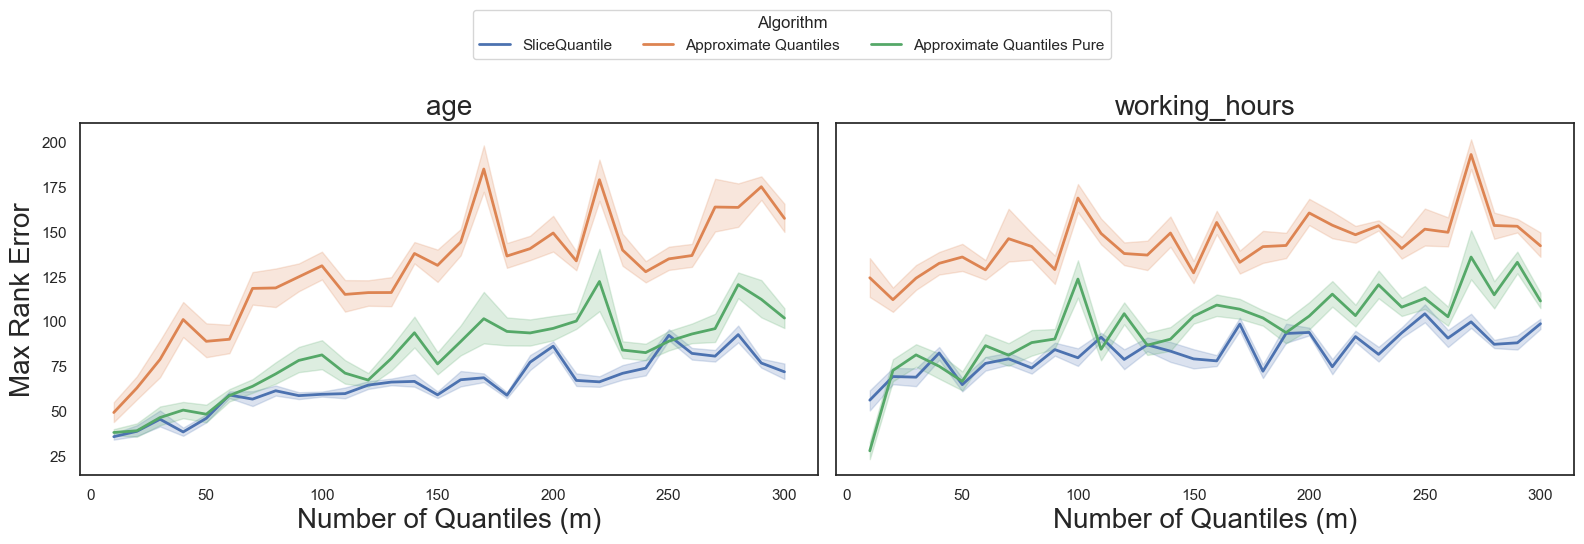

In [258]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each dataset
for i, data_dict in enumerate(DATASET):
    ax = axes[i]
    key = data_dict["name"]
    df = DF[DF["dataset"] == key]
    sns.lineplot(
        data=df,
        x="m",
        y="max_error",
        hue="Algorithm",
        errorbar=('ci', 95),  # confidence interval 95%
        linewidth=2,
        ax=ax,
    )
    ax.set_title(key, fontsize=20)
    ax.set_xlabel("Number of Quantiles (m)", fontsize=20)
    ax.set_ylabel("Max Rank Error", fontsize=20)
    # set log scale
    # ax.set_yscale("log")
    ax.legend().remove()  # Remove individual legends

# Remove unused subplots
if len(DATASET) < len(axes):
    for j in range(len(DATASET), len(axes)):
        fig.delaxes(axes[j])

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), title="Algorithm", bbox_to_anchor=(1.0, 1.1))

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 2, 0.95])
plt.show()

# Mean

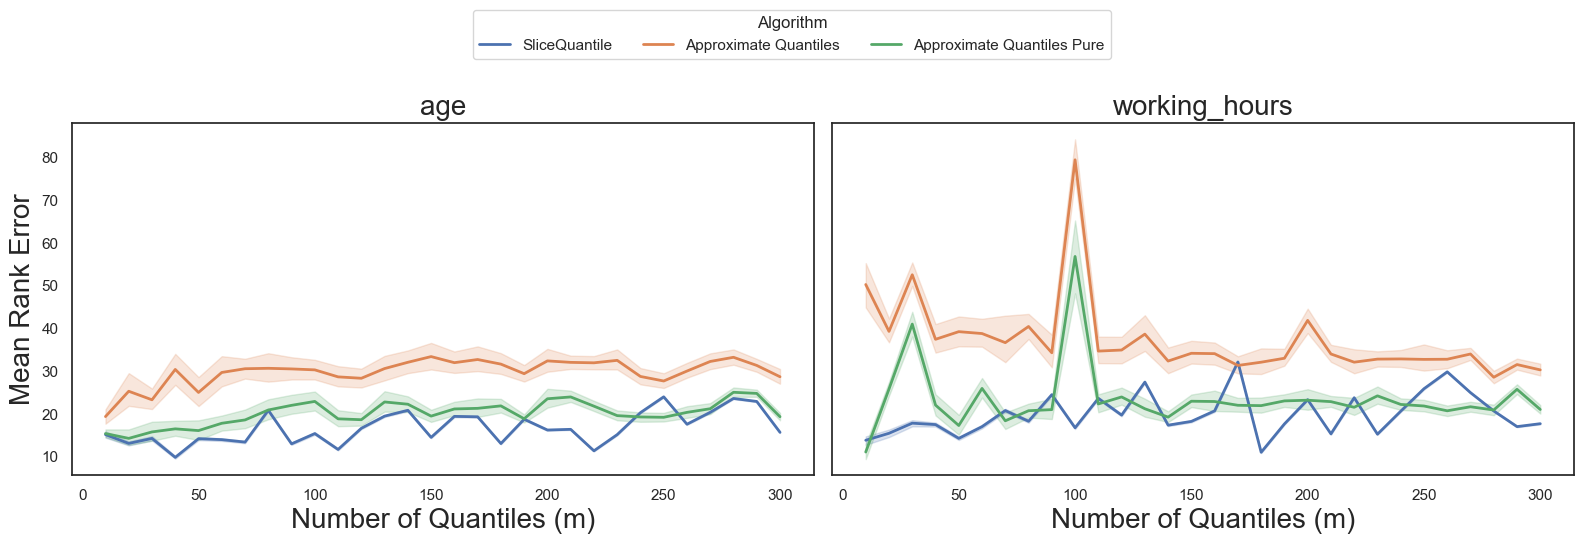

In [259]:
# Create a grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each dataset
for i, data_dict in enumerate(DATASET):
    ax = axes[i]
    key = data_dict["name"]
    df = DF[DF["dataset"] == key]
    sns.lineplot(
        data=df,
        x="m",
        y="mean_error",
        hue="Algorithm",
        errorbar=('ci', 95),  # confidence interval 95%
        linewidth=2,
        ax=ax,
    )
    ax.set_title(key, fontsize=20)
    ax.set_xlabel("Number of Quantiles (m)", fontsize=20)
    ax.set_ylabel("Mean Rank Error", fontsize=20)
    # set log scale
    # ax.set_yscale("log")
    ax.legend().remove()  # Remove individual legends

# Remove unused subplots
if len(DATASET) < len(axes):
    for j in range(len(DATASET), len(axes)):
        fig.delaxes(axes[j])

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), title="Algorithm", bbox_to_anchor=(1.0, 1.1))

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0, 2, 0.95])
plt.show()
